![imagen](img/python.jpg)

## Sesión 9: Pydantic


**Pydantic** es una biblioteca robusta para crear <u>**modelos de datos usando clases de Python y anotaciones de tipo.**</u>

Este método garantiza compatibilidad completa con la verificación de tipos estática.<br> Además, como estas son clases estándar de Python, podemos aprovechar la herencia y definir métodos personalizados para implementar lógica específica.

#### 9.1 Tipos de Campo Básicos

Comenzaremos definiendo campos usando tipos básicos, que solo requieren anotaciones de tipo simples.<br> Veamos un modelo sencillo que captura información sobre un libro.


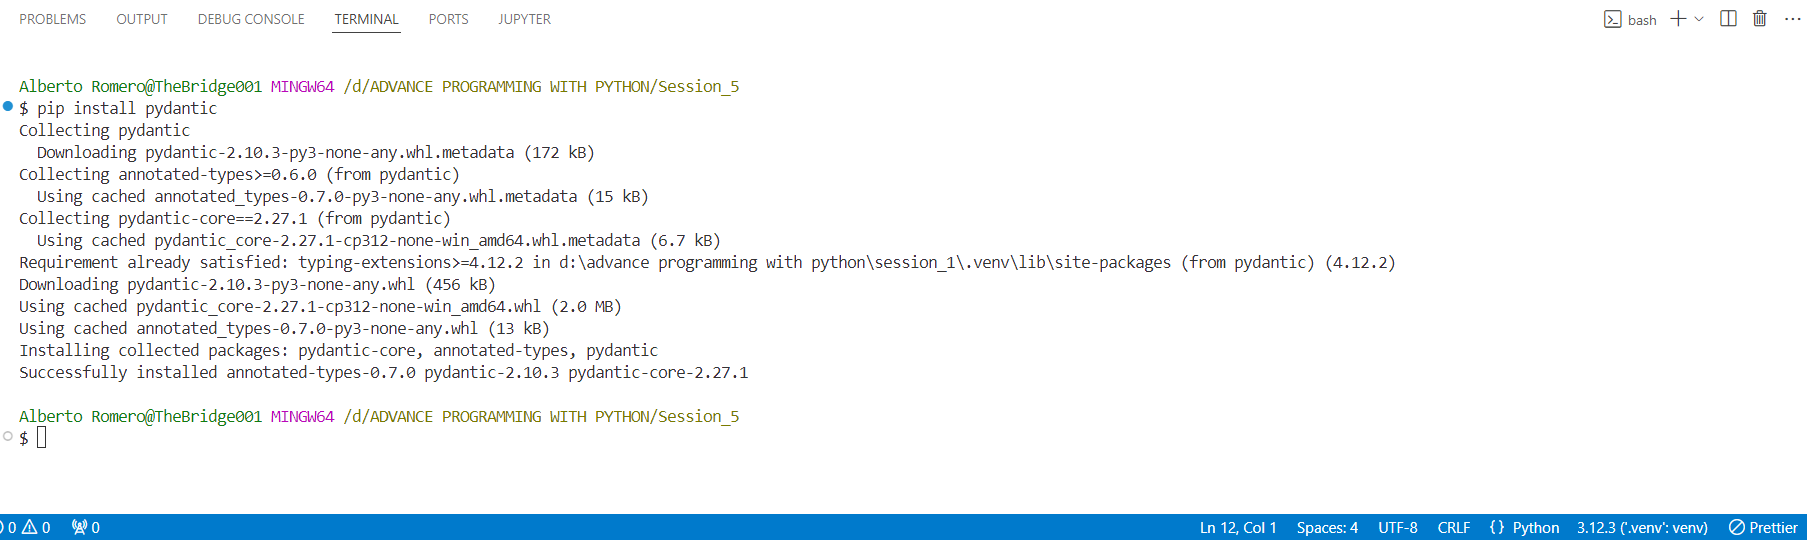


Hemos instalado pydantic en el entorno virtual.


```python
from pydantic import BaseModel

from fastapi import FastAPI

class Book(BaseModel): # inheritance
    title: str
    author: str
    year: int

app = FastAPI()

book = Book(title="Hamlet", author="Shakespeare", year=1623)
print(book)
```

Obtenemos el siguiente resultado:

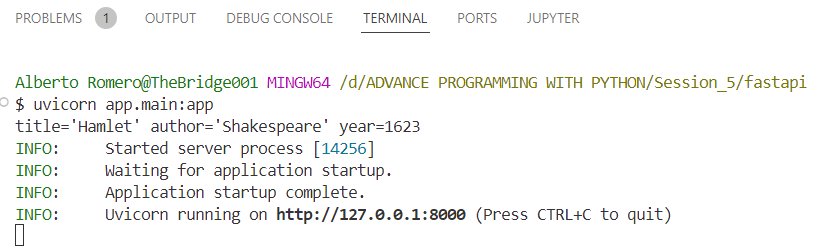

Solo necesitamos listar los <u>nombres de los campos y especificar sus tipos usando anotaciones de tipo.</u><br> No estamos limitados solo a tipos escalares.<br> También podemos usar tipos compuestos como listas y tuplas, o incluso clases como datetime y enum.

#### 9.2 Enum y date


```python
from datetime import date
from enum import Enum

from pydantic import BaseModel

from fastapi import FastAPI

app = FastAPI()


class Gener(str, Enum):
    FANTASY = "FANTASY"
    MYSTERY = "MYSTERY"
    HORROR = "HORROR"


class BiggerBook(BaseModel):
    title: str
    author: str
    price: int
    gener: Gener
    published: date
    awards: list[str]


book2 = BiggerBook(
    title="Hamlet",
    author="Shakespeare",
    price=15,
    gener=Gener("MYSTERY"),
    published=date(1603, 1, 1),
    awards=["best-selling", "most-recommended"],
)
print(book2)

# Invalid gener
try:
    book3 = BiggerBook(
        title="Hamlet",
        author="Shakespeare",
        price=15,
        gener=Gener("MISTAKEN"),
        published=date(1603, 1, 1),
        awards=["best-selling", "popular"],
    )
except ValueError as e:
    print(str(e))


# Invalid published
try:
    book4 = BiggerBook(
        title="Hamlet",
        author="Shakespeare",
        gener=Gener("MYSTERY"),
        price=15,
        published=date(1603, 1, 51),
        awards=["best-selling", "popular"],
    )
except ValueError as e:
    print(str(e))


# Valid
book5 = BiggerBook(
    title="Hamlet",
    author="Shakespeare",
    gener=Gener("MYSTERY"),
    price=15,
    published=date(1603, 1, 1),
    awards=["best-selling", "popular"],
)
print(book5)

```

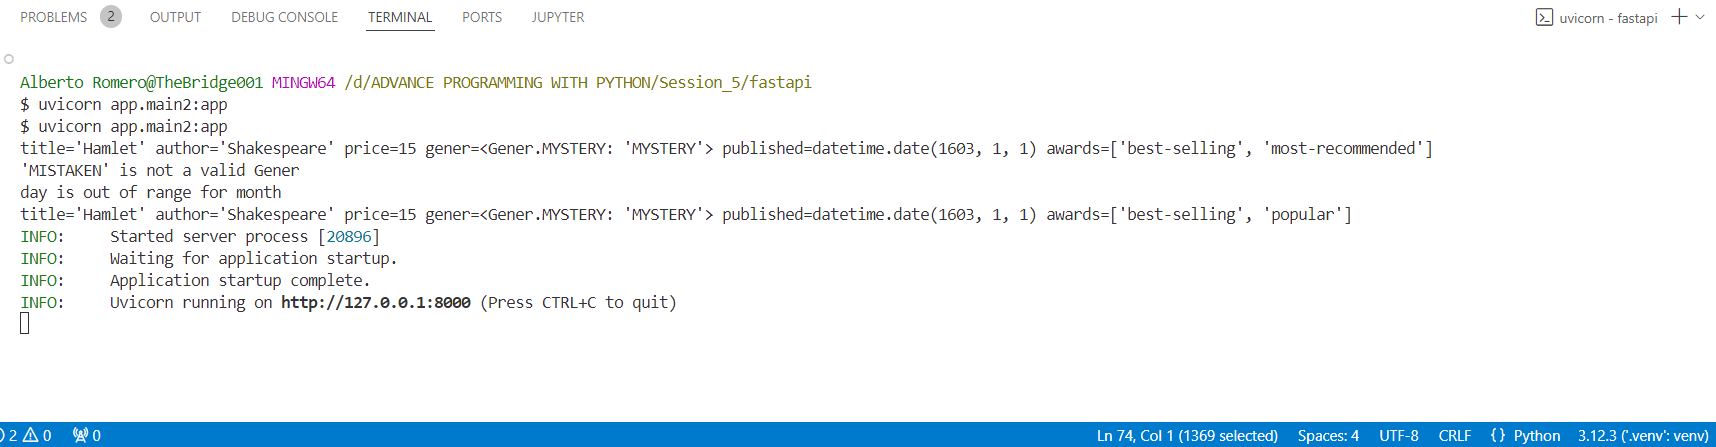

#### 9.3 Más sobre sub-objetos
Esta es una característica poderosa, que soporta tipos de campo complejos. <br> Además, <u>**los campos pueden ser modelos de Pydantic en sí mismos**</u>, lo que significa que puedes incluir sub-objetos.

```python

from datetime import date
from enum import Enum
from pydantic import BaseModel

from fastapi import FastAPI

class Gener(str, Enum):
    FANTASY = "FANTASY"
    MYSTERY = "MYSTERY"
    HORROR = "HORROR"

class Library(BaseModel):
    name: str
    postal_code: str
    city: str
    country: str

class BookForALibrary(BaseModel):
    title: str
    author: str
    price: int
    gener: Gener
    published: date
    awards: list[str]
    library: Library

app = FastAPI()

book6 = BookForALibrary(
    title="Hamlet",
    author="Shakespeare",
    price=15,
    gener=Gener("MYSTERY"),
    published=date(1603, 1, 1),
    awards=["best-selling", "most-recommended"],
    library=Library(
        name="Old Library", postal_code="123ABC", city="Madrid", country="Spain"
    ),
)
print(book6)

# Invalid library
try:
    book7 = BookForALibrary(
        title="Hamlet",
        author="Shakespeare",
        price=15,
        gener=Gener("MYSTERY"),
        published=date(1603, 1, 1),
        awards=["best-selling", "popular"],
        library=Library(name="Old Library", postal_code="123ABC", city="Madrid"),
    )
except ValueError as e:
    print(str(e))
```
Veamos los resultados.

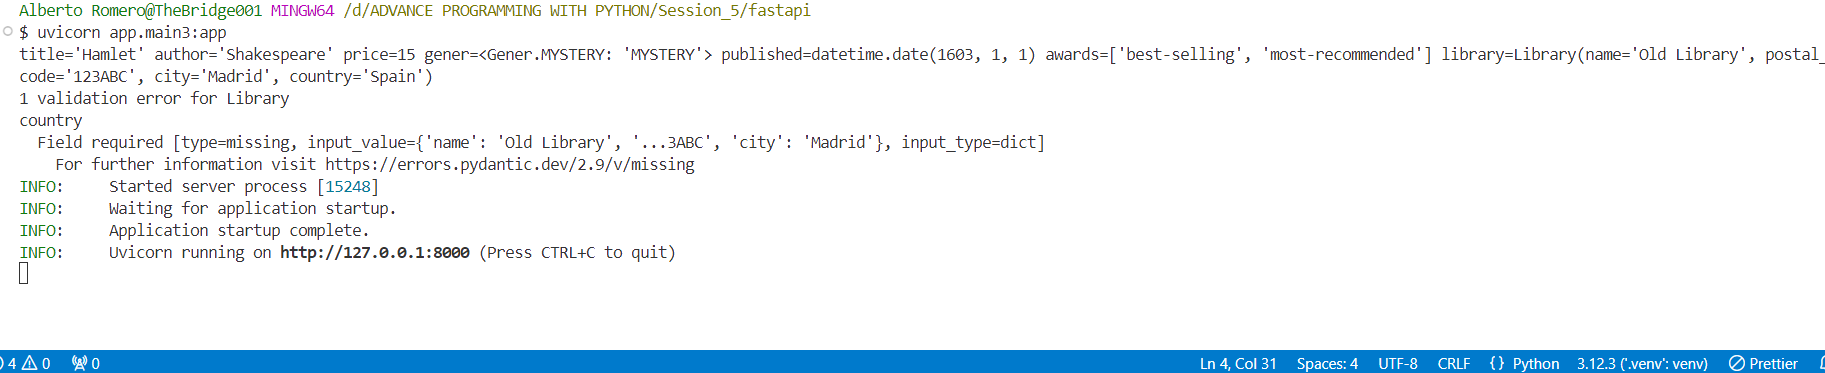

#### 9.4 Diccionarios como objetos

También podemos insertar un diccionario en lugar de un objeto Library.

```python

book8 = BookForALibrary(
    title="Othello",
    author="Shakespeare",
    price=15,
    gener=Gener("MYSTERY"),
    published=date(1603, 1, 1),
    awards=["best-selling", "most-recommended"],
    library={
        "name": "New Library",
        "postal_code": "123ABC",
        "city": "Madrid",
        "country": "Spain",
    },
)
print(book8)
```

#### 9.5 Campos Opcionales y Valores por Defecto

En muchos casos algunos campos pueden ser opcionales (ya que pueden no ser relevantes para todas las instancias).<br>
También es común proporcionar un valor por defecto para un campo cuando no se establece explícitamente.

Esto se puede lograr fácilmente usando la anotación de tipo | None.


```python
from pydantic import BaseModel

from fastapi import FastAPI


class Book(BaseModel):
    title: str
    shop: str | None = None
    anonymous: bool = True


app = FastAPI()

book = Book(title="MacBeth")
print(book)
```

Veamos los resultados:

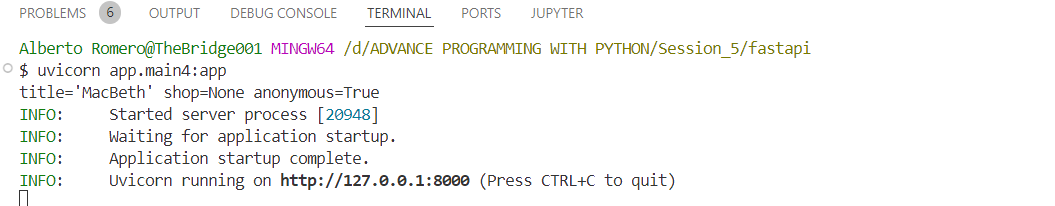

#### 9.6 ¡Advertencia! Tipos dinámicos

datetime se evalúa solo una vez cuando se importa la clase

```python
import time
from datetime import datetime

from pydantic import BaseModel

from fastapi import FastAPI


class TimeStamp(BaseModel):
    # ¡No hagas esto!!!
    # ¡No funcionará!
    my_timestamp: datetime = datetime.now()


app = FastAPI()

time1 = TimeStamp()  # ¡datetime.now() NO SE EJECUTA DE NUEVO!
print(time1.my_timestamp)

time.sleep(1)  # Esperar un segundo

time2 = TimeStamp() # ¡datetime.now() NO SE EJECUTA DE NUEVO!
print(time2.my_timestamp)


print(time1.my_timestamp < time2.my_timestamp)  # False



```

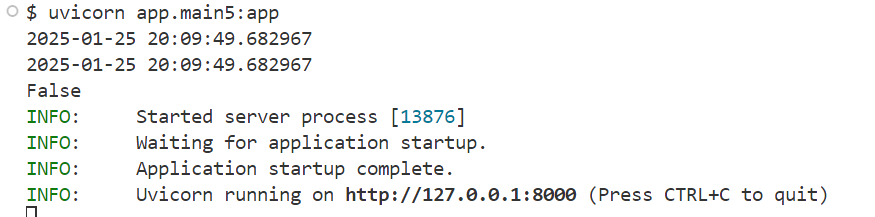

#### 9.7 Función Field
Utilizaremos la función Field de Pydantic y estableceremos su resultado como el valor por defecto para el campo.

```python
from pydantic import BaseModel, Field, ValidationError

from fastapi import FastAPI

app = FastAPI()


class Book(BaseModel):
    title: str = Field(..., min_length=2)
    pages: int | None = Field(None, ge=0, le=2000)


# Título inválido
try:
    Book(title="A", pages=500)
except ValidationError as e:
    print(str(e))


# Páginas inválidas
try:
    Book(title="Learning Python!", pages=200000)
except ValidationError as e:
    print(str(e))


# Válido
book = Book(title="We learn Python!", pages=100)
print(book)

``

Además de la validación, la función Field se usa para llamar a las funciones cuando se inicializan los modelos de datos.
<br>
<br>

```python
from datetime import datetime

from pydantic import BaseModel, Field

from fastapi import FastAPI

app = FastAPI()


def give_me_a_list():
    return ["a", "b", "c"]


class Model(BaseModel):
    my_list: list[str] = Field(
        default_factory=give_me_a_list
    )  # Nota que las funciones en default_factory no se llaman hasta que las iniciamos en Model()
    my_datetime: datetime = Field(default_factory=datetime.now)
    my_other_list: list[str] = Field(default_factory=list)


object1 = Model()
print(object1.my_list)  # ["a", "b", "c"]
print(object1.my_other_list)  # []

object1.my_list.append("d")
print(object1.my_list)  # ["a", "b", "c", "d"]

object2 = Model()
print(object2.my_list)  # ["a", "b", "c"]
print(object2.my_other_list)  # []

print(object1.my_datetime < object2.my_datetimed)  # True
```



#### 9.8 Validación de emails o URLs

Tipos de campo para validar algunos patrones comunes, como direcciones de correo electrónico o URLs.

```bash
pip install email-validator
```

Y en Python:

```python
from pydantic import BaseModel, EmailStr, HttpUrl, ValidationError

from fastapi import FastAPI

app = FastAPI()


class Client(BaseModel):
    email: EmailStr
    website: HttpUrl


# Email inválido
try:
    Client(email="xxxx", website="https://www.python.org")
except ValidationError as e:
    print(str(e))


# URL inválida
try:
    Client(email="aromerov@faculty.ie.edu", website="wrongpage")
except ValidationError as e:
    print(str(e))


# Válido
client = Client(email="aromerov@faculty.ie.edu", website="https://www.python.org")

print(client)

```
Y funcionará:

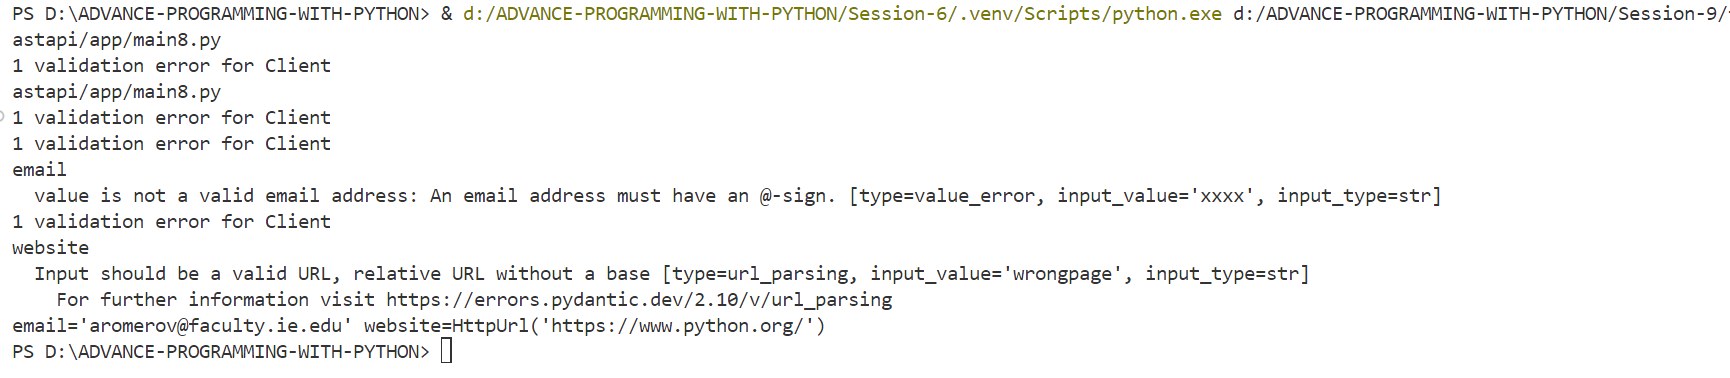


#### 9.9 Variaciones de Modelos

Podemos tener datos que queremos almacenar en el backend y datos que queremos mostrar al usuario.

 **Nota**: Este es un patrón común en FastAPI.

* Defines un modelo de datos para **crear un libro**
* Un modelo de datos para la **respuesta**
* Y un modelo de datos para los datos a **almacenar en la base de datos**


**MakeAPost**: Endpoint POST para crear una nueva publicación.<br>
El usuario nos da el título y el contenido, pero no el ID (que es asignado por la base de datos).

**ReadAPost**: Endpoint GET para obtener el título, contenido e ID de la base de datos.

**JustPost**: Datos POST en la base de datos: título, contenido, ID y también el número de vistas, pero el número de vistas es secreto, solo para nosotros.

```python
# ¡Qué repetitivo!


class MakeAPost(BaseModel):
    title: str
    content: str


class ReadAPost(BaseModel):
    id: int
    title: str
    content: str


class JustPost(BaseModel):
    id: int
    title: str
    content: str
```

Título y contenido se repiten mucho.<br>
Esto suena a...**¡herencia!** :)


```python
from pydantic import BaseModel

from fastapi import FastAPI

app = FastAPI()

# ¡Herencia!


class PostBase(BaseModel):
    title: str
    content: str

    def fragment(self) -> str:
        return f"{self.content[:200]}..."  # Primeros 200 caracteres


class MakeAPost(PostBase):
    pass


class ReadAPost(PostBase):
    id: int


class JustPost(ReadAPost):
    nb_views: int = 0


```

#### 9.10 Validación a Nivel de Campo

`field_validator` es un decorador.<br>El argumento es el valor a validar.

```python
from datetime import date

from pydantic import BaseModel, ValidationError, field_validator


class Book(BaseModel):
    title: str
    published: date

    @field_validator("published")
    def valid_published_book(cls, d: date):
        delta = date.today() - d
        age_of_the_book = delta.days / 365
        if age_of_the_book > 525:
            raise ValueError("¡Eres un incunable!")
        return d


# Edad inválida de un libro
try:
    Book(title="What an old book!", published="1490-01-01")
except ValidationError as e:
    print(str(e))

# Válido
book = Book(title="A new book", published="2025-01-01")
print(book)

```

Y podemos ver la ejecución en la terminal:

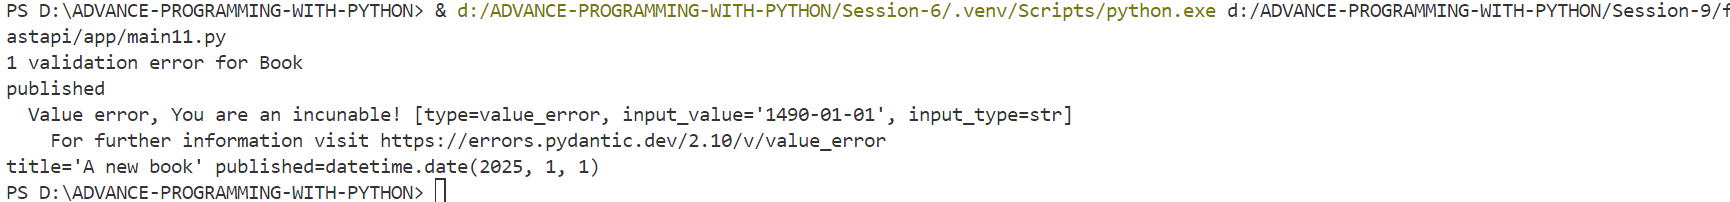


#### 9.11 Validación a Nivel de Objeto
##### 9.11.1 Después del parseo de Pydantic

También podemos validar a nivel del modelo de datos del objeto.

```python
from pydantic import BaseModel, EmailStr, ValidationError, model_validator


class Register(BaseModel):
    email: EmailStr
    password: str
    password_confirmation: str

    @model_validator(mode="after")  # after validation es más seguro en cuanto a tipos
    def check_passwords(cls, values):
        if values.password != values.password_confirmation:
            raise ValueError("¡Ups! Las contraseñas no coinciden")
        return values


# Contraseñas que no coinciden
try:
    Register(
        email="aromerov@faculty.ie.edu", password="Hello", password_confirmation="Bye"
    )
except ValidationError as e:
    print(str(e))

# Ok
registered = Register(
    email="aromerov@faculty.ie.edu", password="Hello", password_confirmation="Hello"
)

print(registered)

```

Observa el código ejecutado en la terminal:

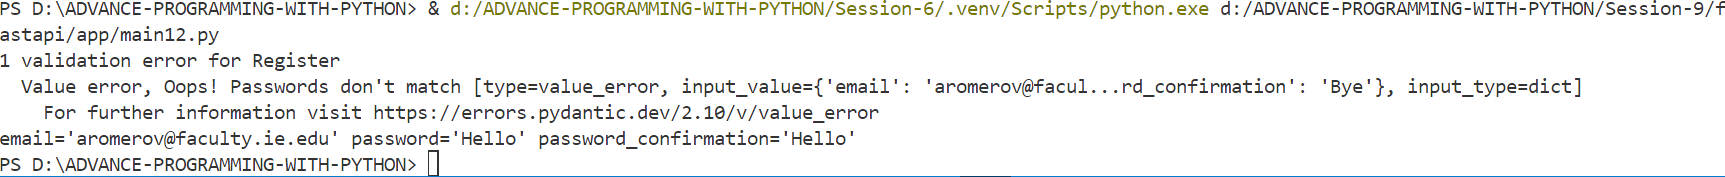

##### 9.11.2 Antes del parseo de Pydantic

Ahora antes del parseo.

```python
from pydantic import BaseModel, field_validator


class Model(BaseModel):
    values: list[int]

    @field_validator("values", mode="before")
    def split_string_values(cls, v):
        if isinstance(v, str):
            return v.split(",")
        return v


m = Model(values="1,2,3")  # mode = "before" significa validar antes del parseo
print(m.values)  # [1, 2, 3]
```

Observa el código ejecutado en la terminal:

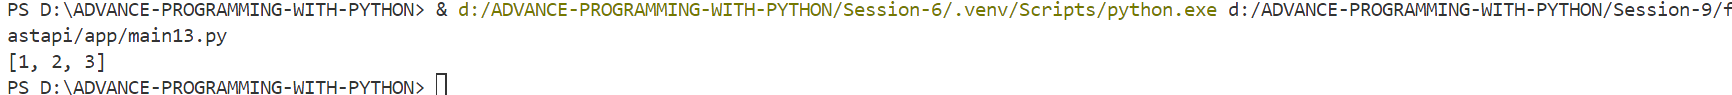

#### 9.12 Objetos Pydantic de uso común

Hay algunas operaciones que se usan mucho con objetos Pydantic.<br>
Recuerda que un objeto Pydantic modela datos.

##### 9.12.1 Objeto Pydantic como diccionario

Llama al método `dump_model`.

```python
import pprint # para imprimir diccionarios de forma ordenada

# Modelo de Datos como un diccionario de Python
book6_python = book6.model_dump()
print("book6_python:")
pprint.pp(book6_python)
pprint.pp(book6_python.get("gener"))
pprint.pp(book6_python["library"])

```
Observa la siguiente ejecución:

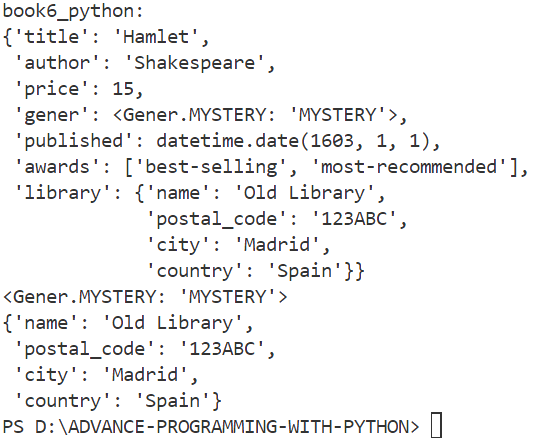


#### 9.12.2 Herencia y desempaquetado de diccionarios

**Esto es muy IMPORTANTE.**
Verás esta situación mucho:

* Creamos un modelo de datos del usuario (título y contenido).
* Lo publicamos en el endpoint POST /posts (el recurso es posts)
* La función devuelve un Modelo de Datos ReadAPost

```python
from pydantic import BaseModel

from fastapi import FastAPI, status

# ¡Herencia!


class PostBase(BaseModel):
    title: str
    content: str

    def fragment(self) -> str:
        return f"{self.content[:200]}..."  # Primeros 200 caracteres


class MakeAPost(PostBase):
    pass


class ReadAPost(PostBase):
    id: int


class JustPost(ReadAPost):
    nb_views: int = 0


class DummyBookDatabase:
    posts: dict[int, JustPost] = {}


db = DummyBookDatabase()


app = FastAPI()


@app.get("/")
async def root():
    return {"message": "Hello World"}


# Este endpoint post /posts recibe un Modelo de Datos con título y contenido
# calcula el id_new
# crea un Modelo de Datos ReadAPost
# que tiene un id y título y contenido
# ** deconstruye el objeto de tipo MakeAPost (como un diccionario)


@app.post("/posts", status_code=status.HTTP_201_CREATED, response_model=ReadAPost)
async def create(
    create_post: MakeAPost,
):  # MakeAPost es un Modelo de Datos con título y contenido
    id_new = max(db.posts.keys() or (0,)) + 1  # La tupla es para hacerlo iterable

    posted = ReadAPost(
        id=id_new, **create_post.model_dump()
    )  # id = id_new, title = ..., content = ...

    db.posts[id_new] = posted
    return posted

```

Y ahora vamos a publicar 2 libros en la base de datos simulada:

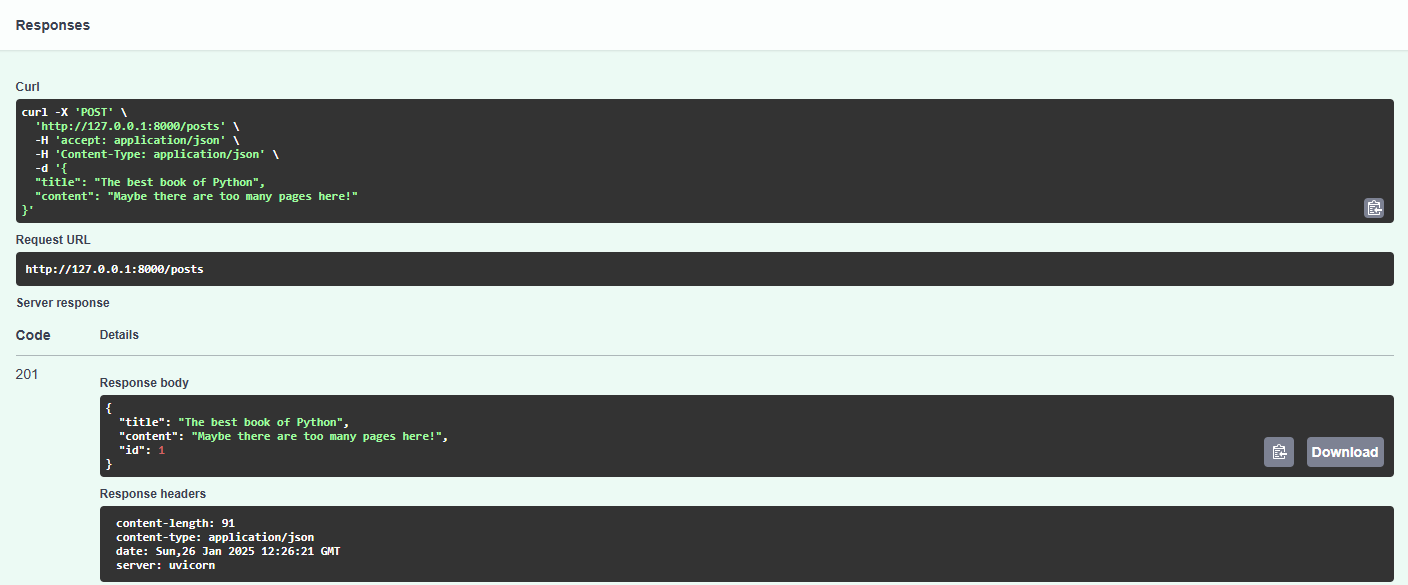

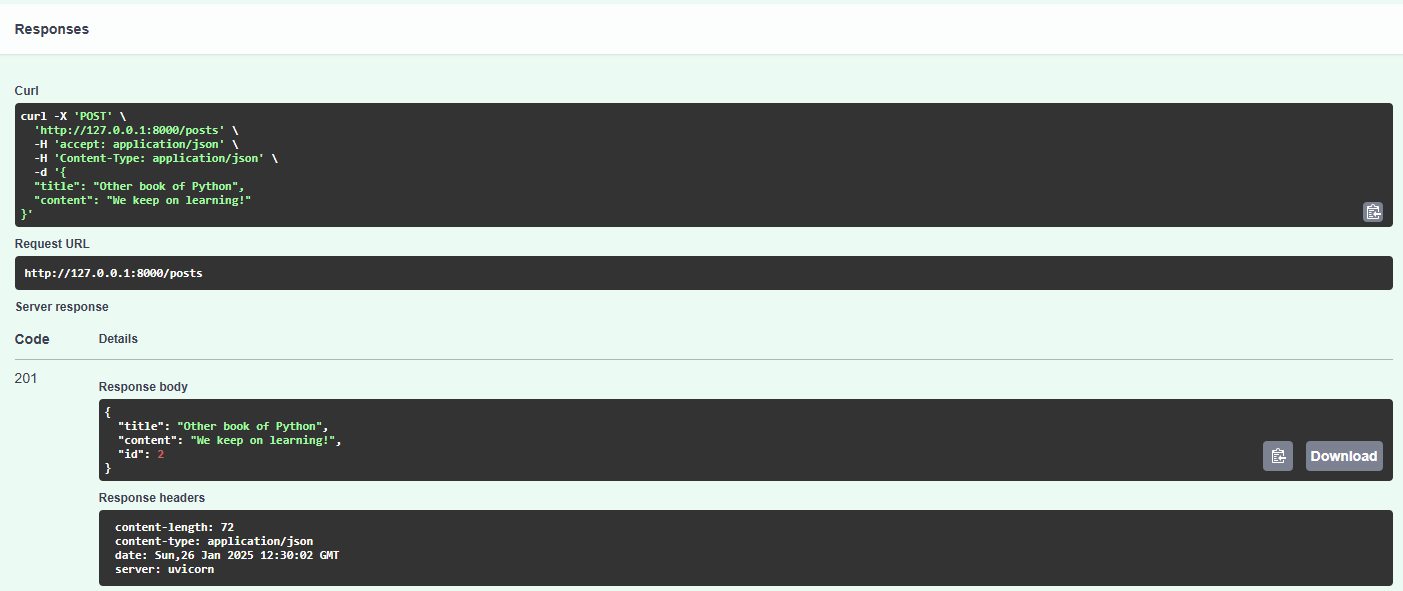

¡Eso es todo lo que necesitamos saber sobre **Pydantic**!


Todo lo cubierto hasta ahora nos ayudará a desarrollar excelentes Modelos de Datos de Pydantic :)